In [1]:
import h5py
import json
import random
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

import pydicom
sys.path.append('./src')
import numpy as np
#from generators import DataGenerator
from generator_hamdi import DataGenerator
from models import dota_energies
from preprocessing import DataRescaler
from preprocessing_hamdi import get_scaling_factors
from tensorflow_addons.optimizers import LAMB
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.config import list_physical_devices
import json
import tensorflow as tf
print(list_physical_devices('GPU'))
from models import dota_energies
from preprocessing import DataRescaler
from evaluation import gamma_analysis, error_analysis
from tqdm import tqdm
from scipy.linalg import norm
import pymedphys



2024-02-28 16:53:20.123713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 16:53:20.543100: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 16:53:22.742064: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-28 16:53:22.742939: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import os
import numpy as np
import pydicom

def load_data_from_directory(directory):
    data = {}

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if filename.endswith('.npy'):
            # Load NumPy file
            var_name = filename[:-4]  # Remove '.npy' from file name
            data[var_name] = np.expand_dims(np.load(file_path),axis=(0,-1))
        elif filename.endswith('.dcm'):
            # Load DICOM file
            var_name = filename[:-4]  # Remove '.dcm' from file name
            data[var_name] = pydicom.dcmread(file_path).pixel_array

    return data

directory_path = r"/home/hamdielsayed/dota/validation_dicoms"
loaded_data = load_data_from_directory(directory_path)

# Access the data like this:
# ct030_data = loaded_data['ct030'] (if ct030.npy or ct030.dcm exists)


In [21]:
loaded_data.keys()

dict_keys(['ct030', '68x68x150_-1000_HU_box_Run_0000', 'ct0', 'ct1000', '68x68x150_1000_HU_box_Run_0000', '68x68x150_0_HU_box_with_slab_of_1000_HU_at_75_85_Run_0000', 'ct7585', '68x68x150_0_HU_box_with_slab_of_1000_HU_at_0_30_Run_0000', '68x68x150_0_HU_box_with_slab_of_1000_HU_at_120_140_Run_0000', '68x68x150_0_HU_box_Run_0000', 'ct120140', 'ctneg1000'])

In [2]:
gpu_index = 1
gpus = tf.config.experimental.list_physical_devices('GPU')
print('Available GPUs: ', gpus)
mem_growth = tf.config.experimental.get_memory_growth(gpus[gpu_index])
print('Memory growth: ', mem_growth)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[gpu_index], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpu_index], True)
    mem_growth = tf.config.experimental.get_memory_growth(gpus[gpu_index])
    print('GPU set to be visible and memory growth set to: ', mem_growth)

Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
Memory growth:  None
GPU set to be visible and memory growth set to:  True


In [3]:
with open('hyperparam.json', 'r') as hfile:
    param = json.load(hfile)


path = r"/tudelft.net/staff-umbrella/simelectrons/OneGeometryOneEnergy"
test_df=pd.read_pickle(os.path.join(path,'test_picklefile.pkl'))

testIDs=test_df['cropped_geometry_name'].tolist()
path_weights = os.path.join(os.path.dirname(path),'weights/weights.ckpt')

with open('scale.json', 'r') as file:
    scale_json = file.read()
scale = json.loads(scale_json)

transformer = dota_energies(
    num_tokens=param['num_tokens'],
    input_shape=param['data_shape'],
    projection_dim=param['projection_dim'],
    num_heads=param['num_heads'],
    num_transformers=param['num_transformers'], 
    kernel_size=param['kernel_size'],
    causal=True
)

# Load weights from checkpoint.
transformer.load_weights(path_weights)


2024-02-28 16:53:33.014639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 16:53:35.366024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22412 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:af:00.0, compute capability: 8.6


In [23]:
scale

{'x_min': -1000.0,
 'x_max': 1294.0,
 'y_min': 0.0,
 'y_max': 0.00020585086255255354,
 'e_min': 100.0,
 'e_max': 100.0}

In [33]:
from pymedphys import gamma
def infer(model,path, filename, scale, ikey='GeometryAll', okey='DoseAll',df=test_df):
    """
    Get model prediction from test sample ID.
    """
    


    geometry_path=os.path.join(path,ikey,filename+'.dcm')
    tmp_geometry=np.swapaxes(pydicom.dcmread(geometry_path).pixel_array,0,2)
    geometry = np.expand_dims(tmp_geometry, axis=(0,-1))
    
    inputs = (geometry - scale['x_min']) / (scale['x_max'] - scale['x_min'])
    ground_truth_filename=df[df['cropped_geometry_name']==filename]['cropped_dose_name'].iloc[0]+'.dcm'
    ground_truth_metadata=pydicom.dcmread(os.path.join(path,okey,ground_truth_filename))
    ground_truth_array=ground_truth_metadata.pixel_array*ground_truth_metadata.DoseGridScaling
    ground_truth= np.swapaxes(ground_truth_array,0,2)
    
    energy_temp = df[df['cropped_geometry_name']==filename]['energy'].iloc[0]
    energy=energy_temp/100.0

    
    # Predict dose distribution
    prediction = model.predict([inputs, np.expand_dims(energy, -1)],verbose=None)
    prediction = prediction * (scale['y_max']-scale['y_min']) + scale['y_min']

    return np.squeeze(geometry), np.squeeze(prediction), np.squeeze(ground_truth)


def gamma_analysis(ground_truth, prediction,scale,cutoff=0.1, dose_threshold=1, distance_threshold=3, resolution=[2,2,2]):
    """
    Performs a gamma analysis for a single instance of ground_truth and prediction.
    Optionally calculates in which part of the beam (quadrant) the failed voxels are.
    """



    # Cut off MC noise
    ground_truth[ground_truth < (cutoff/100) * scale['y_max']] = 0
    prediction[prediction < (cutoff/100) * scale['y_max']] = 0

    # Calculate gamma values.
    axes = (np.arange(ground_truth.shape[0]) * resolution[0],
            np.arange(ground_truth.shape[1]) * resolution[1],
            np.arange(ground_truth.shape[2]) * resolution[2])
    gamma_values = gamma(axes, ground_truth, axes, prediction, dose_threshold,
                         distance_threshold, lower_percent_dose_cutoff=0,max_gamma=1.1)
    gamma_values = np.nan_to_num(gamma_values, 0)

    # Calculate gamma pass rate.
    gamma_pass_rate = np.sum(gamma_values <= 1) / np.prod(gamma_values.shape)

    return gamma_pass_rate*100


def calc_relative_error(ground_truth,prediction):
    n_v=np.prod(ground_truth.shape)
    diff=ground_truth-prediction
    return (1/n_v)* (np.sqrt(np.sum(np.abs(diff)))/np.max(ground_truth)) *100

def calc_RMSE(ground_truth,prediction):
    n_v=np.prod(ground_truth.shape)

    return np.sqrt((1/n_v)* (np.sum((ground_truth-prediction)**2)))



In [1]:
testIDs=test_df['cropped_geometry_name'].tolist()
idx=random.randint(0,len(testIDs))

#idx=random.randint(0,len(testIDs))
filename=testIDs[idx]

print(test_df['energy'].iloc[idx])

#geometry,prediction, ground_truth =infer(transformer,path,testIDs[idx],scale)
geometry,prediction, ground_truth =infer(transformer,path,testIDs[idx],scale)


NameError: name 'test_df' is not defined

1294
100.0


/tmp/ipykernel_3178571/221704308.py:40: RuntimeWarning: divide by zero encountered in divide
  error = abs(prediction_slice - ground_truth_slice) * 100 / ground_truth_slice


 mean= 3.990374570550328


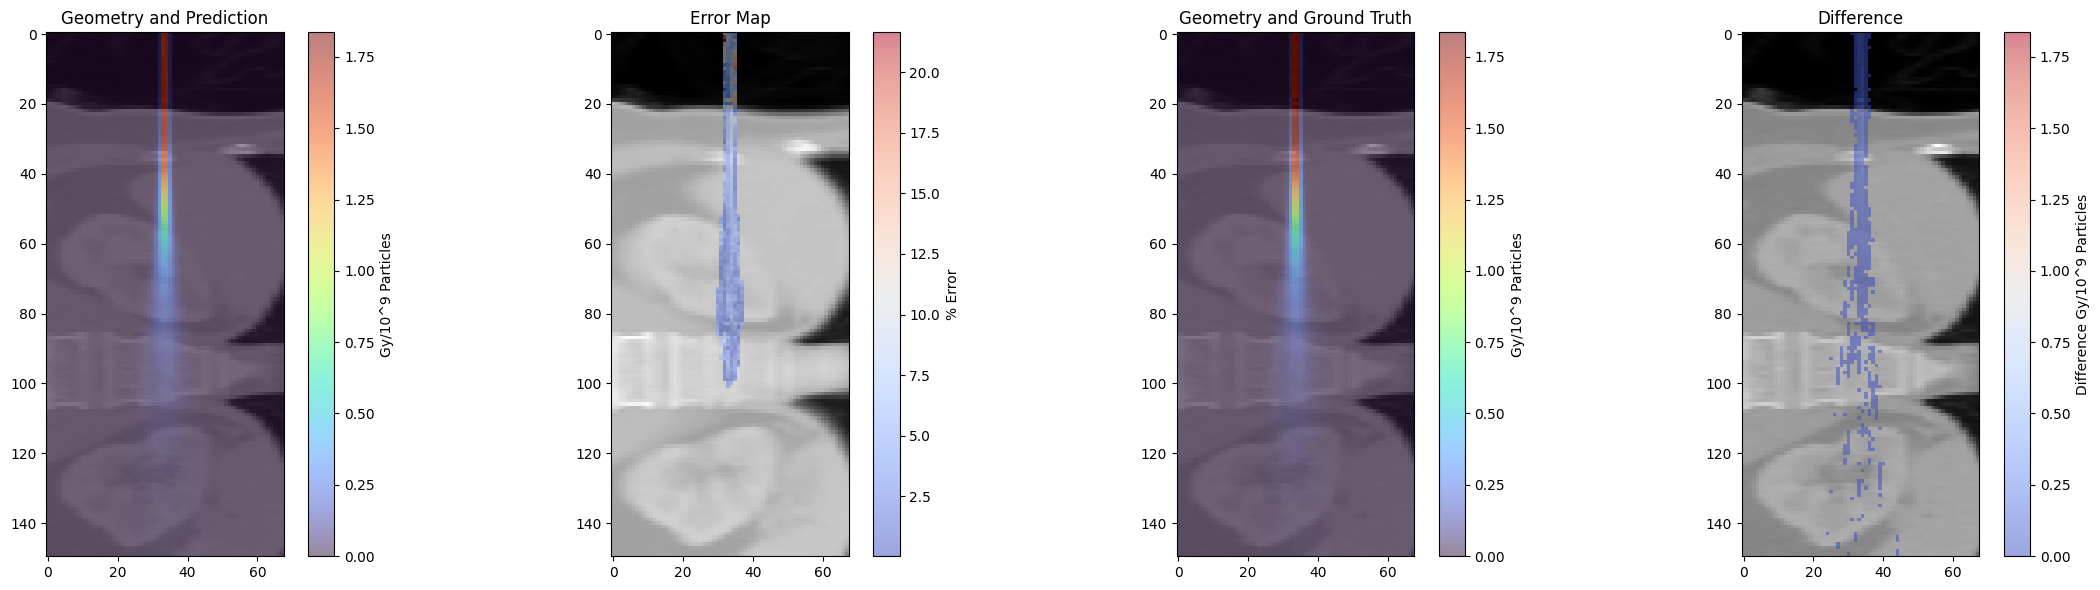

99.99480968858131


In [40]:

slice_index = 34

testIDs=test_df['cropped_geometry_name'].tolist()
idx=random.randint(0,len(testIDs))

print(idx)

#idx=random.randint(0,len(testIDs))
filename=testIDs[idx]

print(test_df['energy'].iloc[idx])

geometry,prediction, ground_truth =infer(transformer,path,testIDs[idx],scale)

# Adjustments to prediction and ground_truth for visualization purposes
prediction = prediction * (1e9 / 1e5)
ground_truth = ground_truth * (1e9 / 1e5)

# Calculate vmin and vmax across both ground_truth and prediction for consistent scaling
vmin = min(ground_truth[:, slice_index, :].min(), prediction[:, slice_index, :].min())
vmax = max(ground_truth[:, slice_index, :].max(), prediction[:, slice_index, :].max())


fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # Adjusted for 4 subplots
        
# First subplot - Geometry and Prediction
img1 = axs[0].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
img2 = axs[0].imshow(prediction[:, slice_index, :], cmap='turbo', alpha=0.5, vmin=vmin, vmax=vmax)
axs[0].set_title('Geometry and Prediction')
cbar1 = fig.colorbar(img2, ax=axs[0], fraction=0.046, pad=0.04)
cbar1.set_label('Gy/10^9 Particles')

# Second subplot - Error Map with geometry included
prediction_slice = prediction[:, slice_index, :].copy()
ground_truth_slice = ground_truth[:, slice_index, :].copy()

zero_out_value = 0.04
ground_truth_slice[ground_truth_slice < zero_out_value * ground_truth.max()] = 0

error = abs(prediction_slice - ground_truth_slice) * 100 / ground_truth_slice
error_correct = np.nan_to_num(error, nan=0.0, posinf=0.0, neginf=0.0)
error_correct[error_correct == 0] = np.nan

print(f" mean= {np.nanmean(error_correct)}")
axs[1].imshow(geometry[:,30:38,:].sum(axis=1), cmap='gray', alpha=1)
img4 = axs[1].imshow(error_correct, cmap='coolwarm', alpha=0.5)
axs[1].set_title('Error Map')
cbar2 = fig.colorbar(img4, ax=axs[1], fraction=0.046, pad=0.04)
cbar2.set_label('% Error')

# Third subplot - Geometry and Ground Truth
img5 = axs[2].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
img6 = axs[2].imshow(ground_truth[:, slice_index, :], cmap='turbo', alpha=0.5, vmin=vmin, vmax=vmax)
axs[2].set_title('Geometry and Ground Truth')
cbar3 = fig.colorbar(img6, ax=axs[2], fraction=0.046, pad=0.04)
cbar3.set_label('Gy/10^9 Particles')

# Fourth subplot - Absolute Difference between Ground Truth and Prediction with Geometry
absolute_difference = np.abs(prediction[:, slice_index, :]-ground_truth[:, slice_index, :])

absolute_difference[np.abs(absolute_difference) < 0.01 * np.abs(absolute_difference).max()]=np.nan
img7 = axs[3].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
img8 = axs[3].imshow(absolute_difference, cmap='coolwarm', alpha=0.5, vmin=vmin, vmax=vmax)
axs[3].set_title('Difference')
cbar4 = fig.colorbar(img8, ax=axs[3], fraction=0.046, pad=0.04)
cbar4.set_label('Difference Gy/10^9 Particles')

plt.tight_layout()
plt.show()

print(gamma_analysis(ground_truth, prediction,scale))

In [7]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, IntSlider
import numpy as np
import matplotlib.pyplot as plt


testIDs=test_df['cropped_geometry_name'].tolist()
idx=random.randint(0,len(testIDs))

#idx=random.randint(0,len(testIDs))
filename=testIDs[idx]

print(test_df['energy'].iloc[idx])

#geometry,prediction, ground_truth =infer(transformer,path,testIDs[idx],scale)
geometry,prediction, ground_truth =infer(transformer,path,testIDs[idx],scale)

slice_index = 34

# Adjustments to prediction and ground_truth for visualization purposes
prediction = prediction * (1e9 / 1e5)
ground_truth = ground_truth * (1e9 / 1e5)

# Calculate vmin and vmax across both ground_truth and prediction for consistent scaling
vmin = min(ground_truth[:, slice_index, :].min(), prediction[:, slice_index, :].min())
vmax = max(ground_truth[:, slice_index, :].max(), prediction[:, slice_index, :].max())





def plot_slices(slice_index):
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # Adjusted for 4 subplots
        
    # First subplot - Geometry and Prediction
    img1 = axs[0].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
    img2 = axs[0].imshow(prediction[:, slice_index, :], cmap='turbo', alpha=0.5, vmin=vmin, vmax=vmax)
    axs[0].set_title('Geometry and Prediction')
    cbar1 = fig.colorbar(img2, ax=axs[0], fraction=0.046, pad=0.04)
    cbar1.set_label('Gy/10^9 Particles')

    # Second subplot - Error Map with geometry included
    prediction_slice = prediction[:, slice_index, :].copy()
    ground_truth_slice = ground_truth[:, slice_index, :].copy()

    zero_out_value = 0.01
    ground_truth_slice[ground_truth_slice < zero_out_value * ground_truth.max()] = 0

    error = abs(prediction_slice - ground_truth_slice) * 100 / ground_truth_slice
    error_correct = np.nan_to_num(error, nan=0.0, posinf=0.0, neginf=0.0)
    error_correct[error_correct == 0] = np.nan

    print(f" max= {np.nanmax(error_correct)}")
    axs[1].imshow(geometry[:,30:38,:].sum(axis=1), cmap='gray', alpha=1)
    img4 = axs[1].imshow(error_correct, cmap='coolwarm', alpha=0.5)
    axs[1].set_title('Error Map')
    cbar2 = fig.colorbar(img4, ax=axs[1], fraction=0.046, pad=0.04)
    cbar2.set_label('% Error')

    # Third subplot - Geometry and Ground Truth
    img5 = axs[2].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
    img6 = axs[2].imshow(ground_truth[:, slice_index, :], cmap='turbo', alpha=0.5, vmin=vmin, vmax=vmax)
    axs[2].set_title('Geometry and Ground Truth')
    cbar3 = fig.colorbar(img6, ax=axs[2], fraction=0.046, pad=0.04)
    cbar3.set_label('Gy/10^9 Particles')

    # Fourth subplot - Absolute Difference between Ground Truth and Prediction with Geometry
    absolute_difference = prediction[:, slice_index, :]-ground_truth[:, slice_index, :]
    
    absolute_difference[absolute_difference < 0.01 * absolute_difference.max()]=np.nan
    img7 = axs[3].imshow(geometry[:, slice_index, :], cmap='gray', alpha=1)
    img8 = axs[3].imshow(absolute_difference, cmap='coolwarm', alpha=0.5)
    axs[3].set_title('Difference')
    cbar4 = fig.colorbar(img8, ax=axs[3], fraction=0.046, pad=0.04)
    cbar4.set_label('Difference')

    plt.tight_layout()
    plt.show()

interactive_plot = interactive(plot_slices, slice_index=(0, geometry.shape[1]-1))
relative_error=calc_relative_error(ground_truth,prediction)
print(relative_error)
interactive_plot

100.0
